In [39]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from tqdm import tqdm
from multiprocessing import Process, Manager
matplotlib.rcParams.update({'font.size': 18})
import time
from decimal import Decimal

# Shape Analysis

In the shape analysis, the PDF has the form

$p(n|\theta) = \prod_{i=1}^M \textrm{Poisson}(n_i, a_i(\theta)) $

where $a_i(\theta)$ is the mean count in bin $i$ and $\theta$ are the free parameters of the model. 

$a_i  = \int_{\textrm{bin_i}}[\mu \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)] \, dx_i\  \approx [\mu \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)] \Delta x $

The likelihood is just:

$\textrm{L}(\mu, \theta) = \prod_{i=1}^M \frac{\Delta x[\mu \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)]^{n_{i}}}{n_i!} e^{-\Delta x[\mu \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)]} $

Again we need to obtain test statistics from 

$\lambda(\mu) = \frac{L(\mu,\hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$

So for each Asimov dataset, we do 2 fits to get $\hat{\mu}, \hat{\theta}$ and $\hat{\hat{\theta}}$. 

Note that in our case, we consider signal is fully known, so we can directly take the signal MC template as $f_s$. When the bin width is small, we might want to do a Gaussian fit to the signal MC template first.

## Making the toy dataset

As oppose to bin counting experiment, shape analysis needs small bin width for better shape fitting. Once Kinga has the proper dataset we can just plug it in.


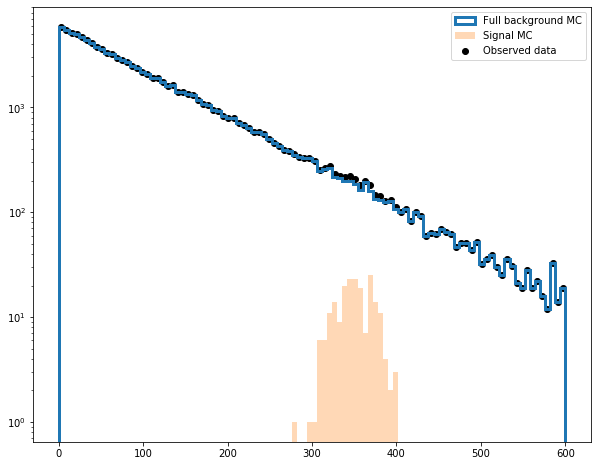

In [2]:
n_bins = 100
max_bin = 600
min_bin = 0
PEAK = 350

# Assuming this is Monte Carlo
plt.figure(figsize=(10,8))
background = np.random.exponential(100, round(1e5))
signal = np.random.normal(PEAK,20, round(2e2))
bkg_count, _, _ = plt.hist(background, bins=n_bins, range=(min_bin, max_bin), histtype='step', linewidth=3, label='Full background MC')
sig_count, _, _ = plt.hist(signal, bins=n_bins, range=(min_bin, max_bin), histtype='stepfilled', alpha=0.3, label='Signal MC')
#sig_count = np.where(sig_count > 0, sig_count, 1e-10)
bin_width = (max_bin-min_bin)/n_bins
bin_center = np.arange(bin_width/2., max_bin, bin_width)
# Assuming this is data
background_with_noise = bkg_count #+ np.random.normal(0, np.sqrt(bkg_count)) 
signal_with_noise = sig_count #+ np.random.normal(0, np.sqrt(sig_count)) 
obs_data = background_with_noise + signal_with_noise
plt.scatter(bin_center, obs_data, color='black', label='Observed data')

plt.yscale('log')
plt.legend(loc='best')
plt.show()


In [52]:
def get_likelihood(mu, s, b, N):
    """
    Get the Poisson likelihood of observed data N given mu, s, b
    
    Parameters:
    s, b: array_like
        Array of bins for the expected signal and background. 
    N: array of bins for observed data
    s = 0 for null hypothesis, 1 for alternative hypothesis
    
    Return: 
    L(N | mu, s, b)
    """
    if s is None:
        average_signal = b
    else:
        average_signal = (mu * s + b)
    return stats.poisson.pmf(average_signal.astype(np.int), N) 

def exp_func(x, coeff, scale):
    """Exponential function
    
    Parameters:
    coeff, scale, bias: float or array_like
        Function parameters
    x: array_like
        Bin centers
    
    Return:
    f(x) = coeff * exp(-scale*x) 
    """
    return coeff * np.exp(-scale * x) 

def gaussian_func(x, mu, sigma, coeff):
    """Gaussian function for the curve fit
    
    Parameters:
    mu, var, coeff: float or array_like
        Function parameters
    x: array_like
        Bin Center
    
    Return:
    f(x) = coeff/[var * sqrt(2pi)] * exp[-1/2 * ((x-mu)/var)^2]    
    """
    return coeff/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5 * np.power((x-mu)/sigma, 2))

def get_gaussian_params(x, template):
    """Get the Gaussian parameters from the signal template
    
    Parameters:
    x: array_like
        Bin centers
    template: array_like
        Signal template
        
    Returns:
    [mu, var, coeff]: array_like
        Parameters of the Gaussian
    """
    popt, pcov = curve_fit(gaussian_func, x, template, bounds=([300, 5, 0], [400, 200, np.inf]), method='trf') # please modify the bounds accordingly to your sig
    return popt 


def sb_func(x, mu, exp_coeff, exp_scale):
    """Basically mu*fs + fb
    
    Parameters: 
    x: array_like
        Bin center
    
    exp_coeff, exp_scale: array_like
        Parameters of the exponential background
    
    Return:
    f(x) = mu*fs + fb
        where fs is the SIGNAL_TEMPLATE obtained from fitting the signal before doing any minimization
    """
    global SIGNAL_TEMPLATE
    return mu * SIGNAL_TEMPLATE + exp_coeff * np.exp(-exp_scale * x) 

def get_theta_doublehat(bc, N):
    """Profile the likelihood for theta given N with mu = 0
    
    Parameters:
    bc: array_like
        Bin center
    N: array_like
        Observed data corresponding to the bin center
    
    Returns:
    [coeff, scale]: list of array_like
        Profile likelihood for the exponential function
    """
    
    popt, pcov = curve_fit(exp_func, bc, N, bounds=(0, np.inf), method='trf')

    return popt 


def get_muhat_thetahat(bc, N):
    """Profile the likelihood for mu and theta given N
    
    Parameters:
    bc: array_like
        Bin center
    N: array_like
        Observed data corresponding to the bin center
        
    Returns:
    [mu, exp_coeff, exp_scale]: list of array_like
        Profile likelihood for the combined function mu * fs + fb
    """
    popt, pcov = curve_fit(sb_func, bc, N, 
                           bounds=([-2, 0, 0],[2, np.inf, np.inf]), 
                           method='trf')
    return popt

def get_signal_template(bc, expected_signal):
    """Get the signal template from the MC bins
    Params:
    bc: array_like
        Bin center
    expected_signal: array_like
        Expected signal from MC
    
    Returns:
    gaus_func: array_like
        The smooth Gaussian function for signal with the same binning scheme
    """
    # Fit the signal template to get a smooth distributions (because the bin is high granularity)
    gauss_params = get_gaussian_params(bc, expected_signal)
    return gaussian_func(bc, gauss_params[0], gauss_params[1], gauss_params[2])

def get_test_statistics(bc, expected_bkg, expected_signal, obs_data, show_plot=False):
    """Get the test statistics given the observed data and expected MC
    
    Params:
    bc: array_like
        Bin center
    expected_bkg, expected_signal: array_like
        Expected bkg and signal from MC
    obs_data: array_like
        Observed data or Asimov data
    
    Returns:
    q0: float
        The test statistics for discovery
    """
    global SIGNAL_TEMPLATE
    
    # Get observed test statistics q_obs
    [exp_coeff, exp_scale] = get_theta_doublehat(bc, obs_data)
    fb_doublehat = exp_func(bc, exp_coeff, exp_scale)
    L_num = get_likelihood(mu=0, s=None, b=fb_doublehat, N=obs_data)
    
    [muhat, exp_coeff, exp_scale] = get_muhat_thetahat(bc, obs_data)
    if muhat < 0: 
        q_obs = 0
    else:
        fb = exp_func(bc, exp_coeff, exp_scale)
        L_deno = get_likelihood(mu=muhat, s=SIGNAL_TEMPLATE, b=fb, N=obs_data)
        q_obs = -2*np.log(L_num/L_deno)
        q_obs = np.sum(q_obs, axis=-1)
        
    if show_plot:
        plt.figure()
        plt.plot(bc, expected_signal, label='expected signal')
        plt.plot(bc, SIGNAL_TEMPLATE, label='template fit signal')
        plt.legend(loc='best')
        plt.show()    
        plt.figure()
        plt.plot(bc, expected_bkg, label='expected background')
        plt.plot(bc, fb_doublehat, label='template fit background')
        plt.legend(loc='best')
        plt.show()       
        
    return q_obs

def generate_asimov_data(q_0, bc, expected_bkg, expected_signal, N_asimov=round(1e3), alternative=False):
    """Child process to generate a list of test statistics
    
    Parameters:
    q_0: List
        Shared object between processes containing the final set of test statistics
    bc: array_like
        Bin center
    expected_bkg, expected_signal: array_like
        Expected bkg and signal from MC
    N_asimov: int
        Number of Asimov datasets to generate
    
    Returns:
    None
    It will just manipulate the shared object (List) by appending the test statistics
    """
    for i in tqdm(range(N_asimov)):
        np.random.seed() # need to reseed because the child process copies the same random state of parent
        if alternative:
            obs_asimov = np.random.poisson(expected_bkg+expected_signal, (expected_bkg.shape[0],)) 
        else:
            obs_asimov = np.random.poisson(expected_bkg, (expected_bkg.shape[0],)) 
        try:
            q_0.append(get_test_statistics(bc, expected_bkg, expected_signal, obs_asimov, show_plot=False))
        except RuntimeError:
            continue   

def discovery_shape_analysis(bc, expected_bkg, expected_signal, obs_data, N_asimov=round(1e5), N_asimov_max=1e7, do_alternative=False, show_plot=False, n_processes=10):
    """Generate the Asimov dataset and compute the pvalue of the observed data
    
    Parameters:
    bc: array_like
        Bin center
    expected_bkg, expected_signal: array_like
        Expected bkg and signal from MC
    obs_data: array_like
        Observed data
    N_asimov: int
        Number of Asimov datasets to generate to compute the p-value
    do_alternative: bool
        Whether to make Asimov dataset for signal hypothesis. Will take twice longer.
    show_plot: bool
        Whether to show the plot of the test statistics
    n_processes: int
        Number of multiprocesses used to generate the test statistics
    
    Return:
    pval: float
        p-value of the observed data
    """
    global SIGNAL_TEMPLATE
    SIGNAL_TEMPLATE = get_signal_template(bc, expected_signal)

    # Get observed test statistics q_obs
    q_obs = get_test_statistics(bc, expected_bkg, expected_signal, obs_data, show_plot=show_plot)

    # Compute the Asimov dataset
    manager = Manager()
    q_0 = manager.list()
   
    N_worse, N_tot = 0, 0
    while N_worse < 25:
        N_child_asimov = int(N_asimov/n_processes)
        process = []
        start = time.time()
        for i in range(n_processes):
            p = Process(target=generate_asimov_data, args=(q_0, bc, expected_bkg, expected_signal, N_child_asimov, False))
            p.start()
            process.append(p)
        for p in process:
            p.join()
        print(f"Generating {N_asimov} test statistics takes {(time.time()-start):.2f} secs.")
        N_worse = np.sum(np.asarray(q_0) > q_obs)
        print(f"Found {N_worse} instances of q_0 > q_obs.")
        
        N_tot += N_asimov
        if N_tot > N_asimov_max:
            print("Can't get enough statistics. Give up.")
            break
        N_asimov *= int(25/(max(N_worse, 1)))
        if N_worse < 25:
            print(f"Getting {Decimal(N_asimov):.0E} more statistics.")
        
    if do_alternative:
        q_1 = manager.list()
        process = []
        start = time.time()
        for i in range(n_processes):
            p = Process(target=generate_asimov_data, args=(q_1, bc, expected_bkg, expected_signal, N_child_asimov, True))
            p.start()
            process.append(p)
        for p in process:
            p.join()
        print(f"Generating {N_asimov} test statistics for signal hypothesis takes {(time.time()-start):.2f} secs.")


    
    if show_plot:
        plt.figure(figsize=(10,8))
        if do_alternative:
            min_q = min(min(q_0), min(q_1))
            max_q = max(max(q_0), max(q_1))
        else:
            min_q = min(q_0)
            max_q = max(q_0)
            
        binContent, _, _ = plt.hist(q_0, label='f($q_{0}$|0)', alpha=0.4, bins=80, range=(min_q, max_q))
        if do_alternative:
            binContentSig, _, _ = plt.hist(q_1, label='f($q_{0}$|1)', alpha=0.4, bins=80, range=(min_q, max_q))

        plt.plot([q_obs, q_obs], [0,np.max(binContent)], label='Observed')
        
        plt.legend(loc='best')
        plt.xlabel('Test statistic $q_{0}$')
        plt.yscale('log')
        plt.ylabel('Entries')
    
    pval = max(1., N_worse)/len(q_0)
    print("\nObserved test statistics: {:.3f}".format(q_obs))
    print("p-value: {:.2E}".format(Decimal(pval)))
    return pval




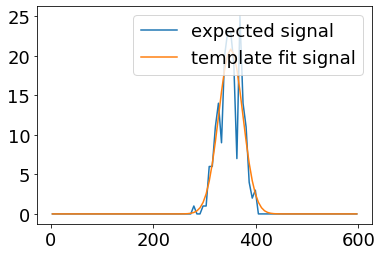

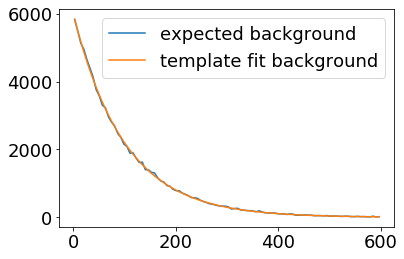

 99%|█████████▉| 331/333 [00:20<00:00, 15.84it/s]

100%|██████████| 333/333 [00:20<00:00, 16.30it/s]


100%|██████████| 333/333 [00:20<00:00, 22.02it/s]


Generating 10000 test statistics takes 20.81 secs.
Found 6 instances of q_0 > q_obs.
Getting 4E+4 more statistics.


100%|██████████| 1333/1333 [01:22<00:00, 16.19it/s]


Generating 40000 test statistics takes 82.45 secs.
Found 21 instances of q_0 > q_obs.
Getting 4E+4 more statistics.


100%|█████████▉| 1331/1333 [01:21<00:00, 16.40it/s]

100%|██████████| 1333/1333 [01:21<00:00, 16.30it/s]

100%|██████████| 1333/1333 [01:22<00:00, 16.22it/s]


Generating 40000 test statistics takes 82.42 secs.
Found 41 instances of q_0 > q_obs.

Observed test statistics: 28.936
p-value: 4.56E-4


0.00045570745804156943

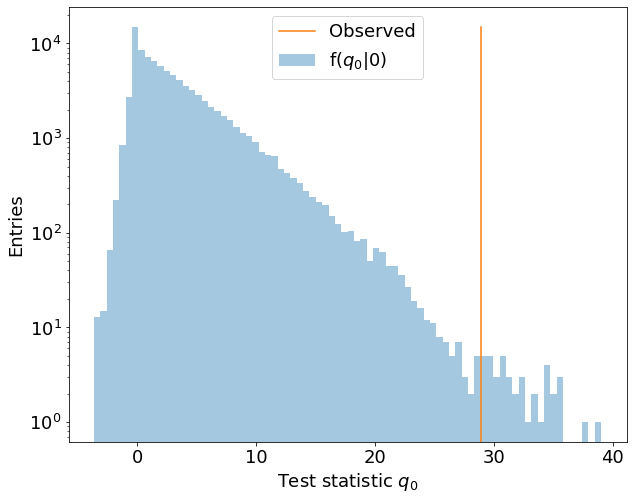

In [53]:
discovery_shape_analysis(bc=bin_center, expected_bkg=bkg_count, expected_signal=sig_count, 
                            obs_data=obs_data, N_asimov=round(1e4), N_asimov_max=1e7, do_alternative=False, show_plot=True, n_processes=30)
    